This notebook fits the iwiw ABM with the method of Xiao et al. to the data.

In [3]:
import pandas as pd
import numpy as np
import json
from itertools import product
from time import time

from SI import SI, DE_fit

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import curve_fit
from scipy.stats import pearsonr

from IPython.display import display, Markdown

In [4]:
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = 10,7

In [15]:
# ABM sample nodes with their empirical adoption times and city ids
nodelist = pd.read_csv('whole_network/nodes_from_edgelist_unique_w_month.csv')
original_timeline = np.concatenate([nodelist.groupby("month").count()["id"].values,[0,0]])
# storing original data in a similar fashion as a simulation output
original_data = {
    "avg_timeline": original_timeline,
    "p": 1e-4,
    "q": 0.1,
    "stop": 129,
    "num_nodes": len(nodelist.index),
    "high": None,
    "low": None
}

First, we run ABMs with different $(p,q)$ pairs. We create 10 simulations for each parameter settings, and then average the results.

In [44]:
# p values and q values to combine and their Cartesian product
pvec = np.linspace(0,0.25,8)*1e-4 # all p values
qvec = np.linspace(0.1,0.8,8) # all q values

In [45]:
pvec

array([0.00000000e+00, 3.57142857e-06, 7.14285714e-06, 1.07142857e-05,
       1.42857143e-05, 1.78571429e-05, 2.14285714e-05, 2.50000000e-05])

In [46]:
qvec

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [47]:
pairs = product(pvec,qvec) # all possible parameter pairs

output = open('whole_network/parameter_sweep_results_2.json','w') # storing simulation results

for i,(p,q) in enumerate(pairs):
    print(i,end=", ")
    tic=time()
    # loading new config
    conf = {"num_runs":10,"p":p,"q":q}
    # creating simulation object
    sim = SI(**conf)
    # running simulation, creating average timeline for number of runs
    res = sim.average_batch(sim.run_batch())
    res.update({"run_id":i})\
    # dumping results
    output.write(json.dumps(res))
    output.write('\n')
    toc=time()
    print("Time elapsed: %.2f s." % (toc-tic))
        
output.close()

0, Time elapsed: 268.79 s.
1, Time elapsed: 278.78 s.
2, Time elapsed: 288.06 s.
3, Time elapsed: 284.34 s.
4, Time elapsed: 283.52 s.
5, Time elapsed: 261.98 s.
6, Time elapsed: 263.61 s.
7, Time elapsed: 264.32 s.
8, Time elapsed: 1337.66 s.
9, Time elapsed: 1926.38 s.
10, Time elapsed: 2057.65 s.
11, Time elapsed: 2117.89 s.
12, Time elapsed: 2134.07 s.
13, Time elapsed: 2090.01 s.
14, Time elapsed: 2101.72 s.
15, Time elapsed: 1912.57 s.
16, Time elapsed: 1565.56 s.
17, Time elapsed: 1991.16 s.
18, Time elapsed: 2121.05 s.
19, Time elapsed: 2144.85 s.
20, Time elapsed: 2096.46 s.
21, Time elapsed: 2077.38 s.
22, Time elapsed: 2080.72 s.
23, Time elapsed: 1854.16 s.
24, Time elapsed: 1679.51 s.
25, Time elapsed: 2045.06 s.
26, Time elapsed: 2122.71 s.
27, Time elapsed: 2126.18 s.
28, Time elapsed: 2172.63 s.
29, Time elapsed: 2085.78 s.
30, Time elapsed: 2019.98 s.
31, Time elapsed: 1857.73 s.
32, Time elapsed: 1803.34 s.
33, Time elapsed: 2134.99 s.
34, Time elapsed: 2236.35 s.
35,

Calculating the corresponding DE $(P,Q)$ pairs.

In [5]:
param_sweep_data = []

with open('whole_network/parameter_sweep_results.json') as f:
    for line in f:
        # loading simulation results
        simulation_results = json.loads(line.strip('\n'))
        # creating fit object
        de_fit = DE_fit(simulation_results)
        # fit parameters
        (P,Q),param_cov = de_fit.fit()
        # storing fit parameters
        param_sweep_data.append({
            "P":P,
            "P_err":np.sqrt(param_cov[0,0]),
            "Q":Q,
            "Q_err":np.sqrt(param_cov[1,1]),
            "p":simulation_results["p"],
            "q":simulation_results["q"]
        })
        
with open('whole_network/parameter_sweep_results_2.json') as f:
    for line in f:
        # loading simulation results
        simulation_results = json.loads(line.strip('\n'))
        # creating fit object
        de_fit = DE_fit(simulation_results)
        # fit parameters
        (P,Q),param_cov = de_fit.fit()
        # storing fit parameters
        param_sweep_data.append({
            "P":P,
            "P_err":np.sqrt(param_cov[0,0]),
            "Q":Q,
            "Q_err":np.sqrt(param_cov[1,1]),
            "p":simulation_results["p"],
            "q":simulation_results["q"]
        })

# parameters to be fitted
param_sweep_data = pd.DataFrame.from_dict(param_sweep_data)
param_sweep_data.head()

/home/bokanyie/spatial_diffusion/SI.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  return self.N * (1-np.exp(-(P+Q)*t))/(1+Q/P*np.exp(-(P+Q)*t))
/home/bokanyie/spatial_diffusion/SI.py:155: RuntimeWarning: overflow encountered in multiply
  return self.N * (1-np.exp(-(P+Q)*t))/(1+Q/P*np.exp(-(P+Q)*t))
/home/bokanyie/spatial_diffusion/SI.py:155: RuntimeWarning: invalid value encountered in true_divide
  return self.N * (1-np.exp(-(P+Q)*t))/(1+Q/P*np.exp(-(P+Q)*t))
/home/bokanyie/spatial_diffusion/SI.py:155: RuntimeWarning: overflow encountered in exp
  return self.N * (1-np.exp(-(P+Q)*t))/(1+Q/P*np.exp(-(P+Q)*t))
/home/ubuntu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


,P,P_err,Q,Q_err,p,q
0,0.000059,0.000001,0.047378,0.000267,0.000025,0.08
1,0.000107,0.000005,0.050674,0.000494,0.000025,0.10
2,0.000214,0.000015,0.051180,0.000823,0.000025,0.12
3,0.000364,0.000033,0.050886,0.001187,0.000025,0.14
4,0.000570,0.000059,0.050260,0.001501,0.000025,0.16


Fitting the linear relationship between the Bass DE parameters $(P,Q)$ and the ABM parameters $(p,q)$:

$$\left(\begin{array}{c}p\\q\end{array}\right) = \underline{\underline{C}}\left(\begin{array}{c}P\\Q\end{array}\right)+\underline{\varepsilon}$$

In [6]:
def param_transform1(X,p1,p2,p5):
    # fitting the first line
    C = (p1,p2)
    eps = p5
    return C[0]*X[0]+C[1]*X[1]+eps
            
def param_transform2(X,p3,p4,p6):
    # fitting the second line
    C = (p3,p4)
    eps = p6
    return C[0]*X[0]+C[1]*X[1]+eps

In [7]:
(p1,p2,p5), pcov1 = curve_fit(
    param_transform1,
    param_sweep_data.values[:,[0,2]].T,
    param_sweep_data.values[:,4]
)

(p3,p4,p6), pcov2 = curve_fit(
    param_transform1,
    param_sweep_data.values[:,[0,2]].T,
    param_sweep_data.values[:,5]
)

# fit parameters
C = np.matrix([[p1,p2],[p3,p4]])
eps = np.matrix([p5,p6]).T

# whole transformation
def param_transform(X):
    return C*X+eps

In [8]:
param_sweep_data["p_est"] = param_sweep_data.apply(lambda row:
                        np.array((param_transform(np.matrix([row["P"],row["Q"]]).T).T))[0][0]
                       ,axis=1)

param_sweep_data["q_est"] = param_sweep_data.apply(lambda row:
                        np.array((param_transform(np.matrix([row["P"],row["Q"]]).T).T))[0][1]
                       ,axis=1)

Checking the relationship of the simulation input parameters and the DE estimated $p_{est}$ and $q_{est}$.

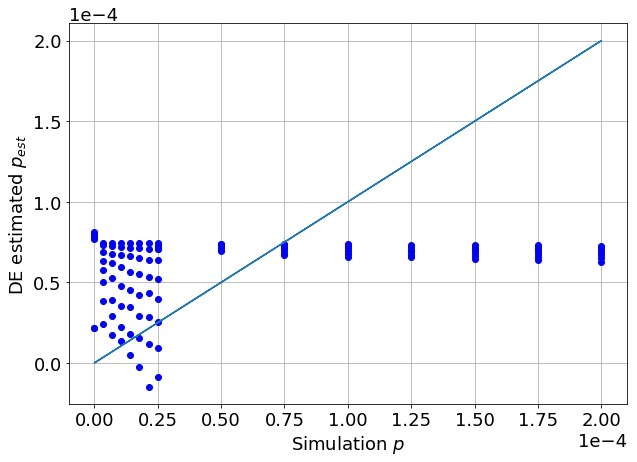

In [9]:
plt.figure(figsize=(10,7))
plt.plot(param_sweep_data["p"],param_sweep_data["p_est"],'bo')
plt.plot(param_sweep_data["p"],param_sweep_data["p"])
plt.xlabel("Simulation $p$")
plt.ylabel("DE estimated $p_{est}$")
plt.gca().ticklabel_format(style='sci',scilimits=(2,4))
plt.grid()
plt.show()

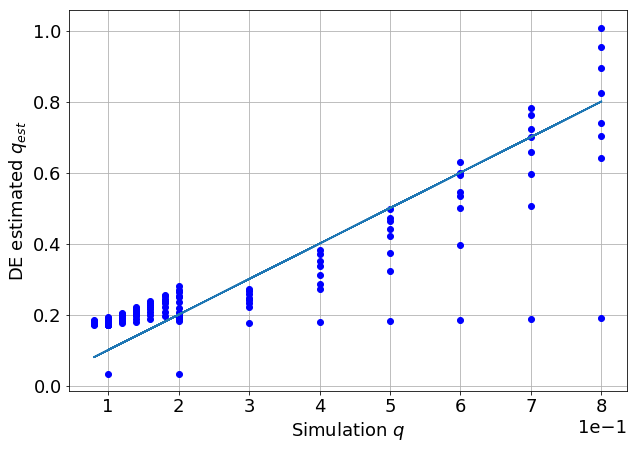

In [10]:
plt.figure(figsize=(10,7))
plt.plot(param_sweep_data["q"],param_sweep_data["q_est"],'bo')
plt.plot(param_sweep_data["q"],param_sweep_data["q"])
plt.xlabel("Simulation $q$")
plt.ylabel("DE estimated $q_{est}$")
plt.gca().ticklabel_format(style='sci',scilimits=(2,4))
plt.grid()
plt.show()

Calculating DE fit to the data and converting $(\hat{P},\hat{Q})$ to $(p_0,q_0)$, then plotting it. Input $p$ and input $q$ serve as starting points for best nonlinear fit search.

In [16]:
de_fit_data = DE_fit(original_data)
(PH,QH),dp_cov = de_fit_data.fit() # P_hat, Q_hat

In [17]:
PH

0.0002226900918088317

In [18]:
QH

0.09441820037797195

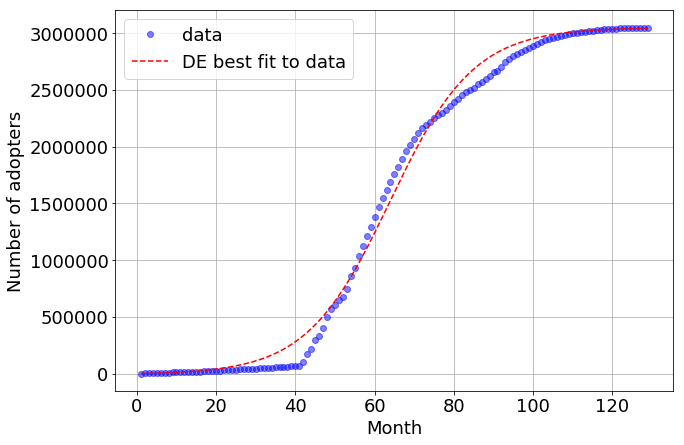

In [19]:
plt.figure(figsize=(10,7))
plt.plot(de_fit_data.t,original_data['avg_timeline'].cumsum(),'bo',label='data',alpha=0.5)
plt.plot(de_fit_data.t,de_fit_data.bass_solution(de_fit_data.t,PH,QH),'r--',label='DE best fit to data')
# plt.annotate(r'$\hat{P}=%.6f$' % PH,(100,50000))
# plt.annotate(r'$\hat{Q}=%.2f$' % QH,(100,25000))
plt.legend()
plt.xlabel("Month")
plt.ylabel("Number of adopters")
plt.grid()
plt.show()

In [20]:
p0,q0 = map(float,param_transform(np.matrix([PH,QH]).T))

ABM parameters corresponding to best fitting DE.

In [21]:
print("p0",p0,"q0",q0)

p0 7.414185851070057e-05 q0 0.17702462162672947


Setting up parameter search grid, and optimizing for least deviating parameter set.

In [22]:
# grid spacing
dp = 0.00001
dq = 0.01

# search matrix
A = list(product([-1,0,1],[-1,0,1]))

# first timestep
new_candidates = np.array(A)
already_visited = np.array([])
sse_errors = np.array([])

counter=0
while len(new_candidates)>0:
    # list to store all errors calculated
    new_errors = []
    for coord in new_candidates:
        # grid p,q at position coord
        p = p0 + coord[0] * dp
        q = q0 + coord[1] * dq
        # give p and q to config
        conf = {"num_runs":1,"p":p,"q":q}
        sim = SI(**conf)
        # run simulation, calculate SSE
        err = np.sum((np.cumsum(np.array(sim.average_batch(sim.run_batch())["avg_timeline"]))-np.cumsum(original_timeline))**2)
        new_errors.append(err)
    new_errors = np.array(new_errors)
    
    # append errors and visited positions to lists
    if len(already_visited)>0:
        already_visited = np.concatenate([already_visited,new_candidates])
    else:
        already_visited = new_candidates
    if len(sse_errors)>0:
        sse_errors = np.concatenate([sse_errors,new_errors])
    else:
        sse_errors = new_errors
     
    # extend the border of the search grid
    new_candidates = []
    # get the two minimum SSE positions
    proposal_centers = np.argsort(sse_errors)[0:2]

    # place search matrix on top of minimum SSE positions
    for c in already_visited[proposal_centers]:
        for elem in A:
            # propose new p and q search positions on grid (these are in grid coordinates...)
            pc,qc = elem[0]+c[0],elem[1]+c[1]
            if (pc,qc) not in set([(p,q) for p,q in list(already_visited)]):
                new_candidates.append(np.array((pc,qc)))
    new_candidates = np.array(new_candidates)
    counter+=1
    print("End of round",counter," num new candidates was",len(new_candidates))

End of round 1  num new candidates was 6
End of round 2  num new candidates was 0


We got back the best fit, if we optimize with smaller steps, maybe there is a slight change in the third valuable digit, but it does not really matter.

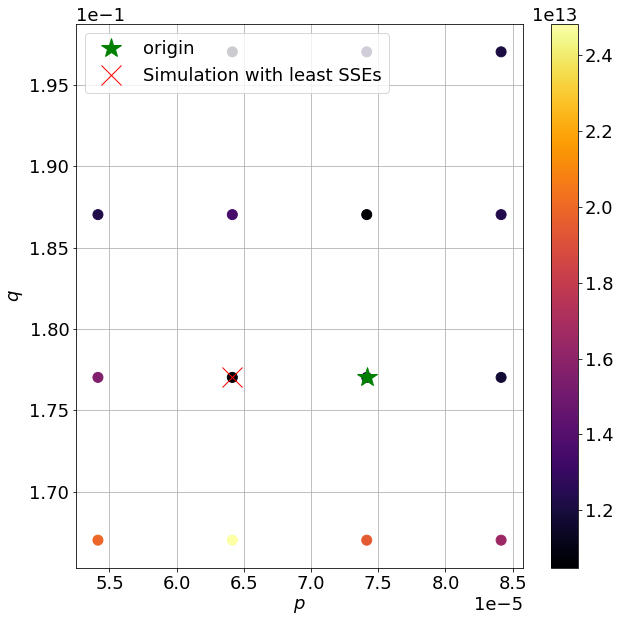

In [23]:
plt.figure(figsize=(10,10))

plt.plot(p0,q0,'g*',markersize=20,label="origin")
plt.plot(p0+dp*already_visited[np.argmin(sse_errors),0],q0+dq*already_visited[np.argmin(sse_errors),1],'rx',markersize=20,label="Simulation with least SSEs")
plt.scatter(p0+dp*already_visited[:,0],q0+dq*already_visited[:,1],s=100,c=sse_errors,cmap='inferno')

plt.grid()
plt.xlabel("$p$")
plt.ylabel("$q$")
# plt.xlim(1.6e-4,2.3e-4)
# plt.ylim(0.09,0.15)
plt.gca().ticklabel_format(style='sci',scilimits=(2,4))
plt.legend(loc="upper left")
plt.colorbar()
plt.show()

Final parameter values for the best fitting ABM.

In [24]:
p_end = p0+dp * already_visited[np.argmin(sse_errors)][0]
q_end = q0+dq * already_visited[np.argmin(sse_errors)][1]

In [25]:
p_end

6.414185851070057e-05

In [26]:
q_end

0.17702462162672947

In [27]:
display(Markdown((rf"""
$p$={p_end:.4}

$q$={q_end:.4}""")))


$p$=6.414e-05

$q$=0.177

Running ABM with final parameters.

In [30]:
conf = {"num_runs":10,"p":p_end,"q":q_end}
sim = SI(**conf)
res = sim.average_batch(sim.run_batch())

In [31]:
conf = {"num_runs":10,"p":p0,"q":q0}
sim = SI(**conf)
res2 = sim.average_batch(sim.run_batch())

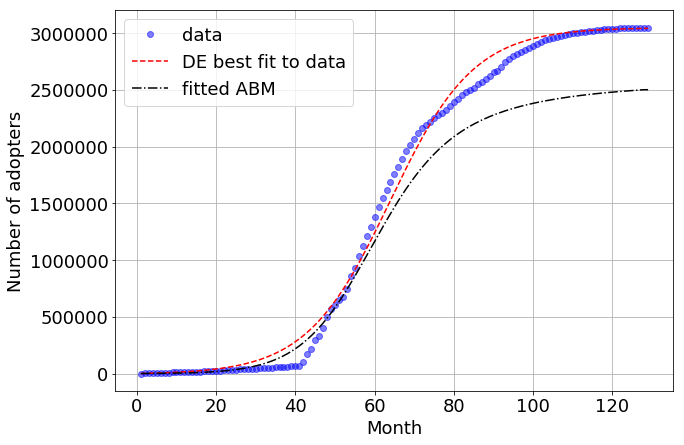

In [32]:
plt.figure(figsize=(10,7))
plt.plot(de_fit_data.t,original_data['avg_timeline'].cumsum(),'bo',label='data',alpha=0.5)
plt.plot(de_fit_data.t,de_fit_data.bass_solution(de_fit_data.t,PH,QH),'r--',label='DE best fit to data')
plt.plot(de_fit_data.t,np.cumsum(res['avg_timeline']),'-.',color='black',label="fitted ABM")

# plt.annotate(r'$p_{opt}=%.6f$' % p_end,(90,50000))
# plt.annotate(r'$q_{opt}=%.2f$' % q_end,(90,25000))
plt.legend()
plt.xlabel("Month")
plt.ylabel("Number of adopters")
plt.grid()
plt.show()

The same figure just not cumulative.

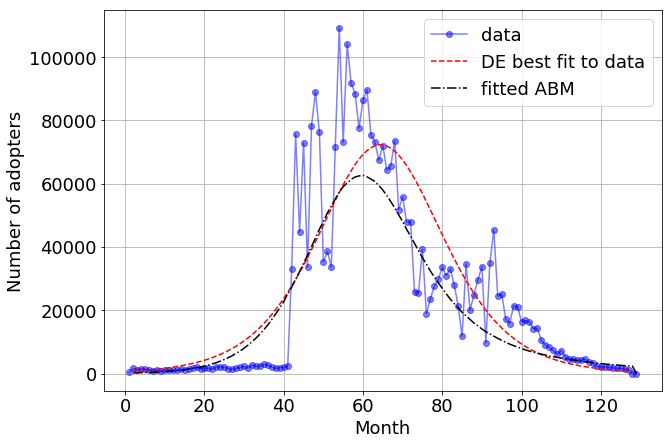

In [33]:
plt.figure(figsize=(10,7))
plt.plot(de_fit.t,original_data['avg_timeline'],'bo-',label='data',alpha=0.5)
plt.plot(de_fit.t[1:],np.diff(de_fit.bass_solution(de_fit.t,PH,QH)),'r--',label='DE best fit to data')
plt.plot(de_fit.t[1:],np.diff(np.cumsum(res['avg_timeline'])),'-.',color='black',label="fitted ABM")
#plt.annotate(r'$p_{opt}=%.6f$' % p_end,(90,50000))
#plt.annotate(r'$q_{opt}=%.2f$' % q_end,(90,25000))
plt.legend()
plt.xlabel("Month")
plt.ylabel("Number of adopters")
plt.grid()
plt.show()

Some magnification.

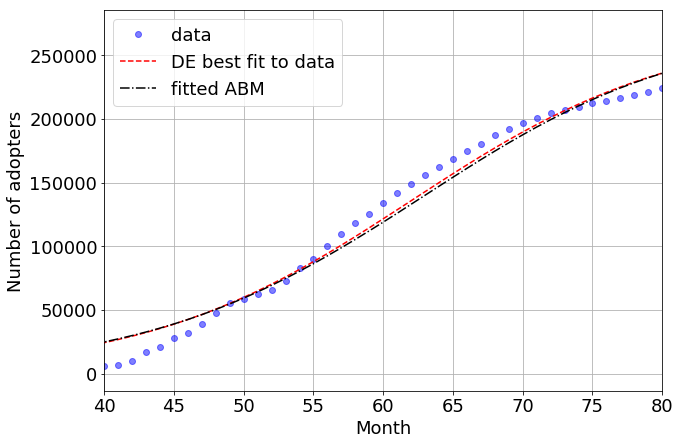

In [73]:
plt.figure(figsize=(10,7))
plt.plot(de_fit.t,original_data['avg_timeline'].cumsum(),'bo',label='data',alpha=0.5)
plt.plot(de_fit.t,de_fit.bass_solution(de_fit.t,PH,QH),'r--',label='DE best fit to data')
plt.plot(de_fit.t,np.cumsum(res['avg_timeline']),'-.',color='black',label="fitted ABM")
plt.xlabel("Month")
plt.ylabel("Number of adopters")
plt.legend()
plt.grid()
plt.xlim(40,80)
#plt.ylim(0,5e3)
plt.show()

# Visualizing peak adoption times

Loading city data.

In [4]:
citydata = pd.read_csv('citypop.csv',sep=";").set_index("cityid")
citydata.head()

,cityid_new,pop,pop_log
cityid,,,
379,1,1740041,6.240560
380,2,207594,5.317215
381,4,166823,5.222256
382,3,170052,5.230582
383,5,156801,5.195349


Determining empirical adoption peak times from data.

In [5]:
original_timeline = pd.read_csv('./vertices_fs.csv')
original_timeline.head()

,id,comm_mem,cityid,month
1,72367576,55,78567,78.0
2,64248926,55,379,120.0
3,70127822,218,46758,94.0
4,71295318,167,393,84.0
5,71889448,55,13943,80.0


Creating smoothed timelines (simple numpy arrays) per cityid.

In [6]:
window = 5
city_timelines = pd.DataFrame(original_timeline.groupby(['cityid','month']).count()["id"]).reset_index()
city_timelines = city_timelines.pivot_table(index="cityid",columns="month",values="id").fillna(0)
smoothed = city_timelines.apply(lambda row: np.convolve(np.ones(window),np.array(row),mode='same')/window,axis=1)

In [7]:
smoothed.head()

cityid
379    [47.6, 70.8, 91.0, 104.0, 90.8, 90.8, 81.8, 76...
380    [0.0, 0.4, 0.4, 0.4, 0.6, 1.0, 0.6, 1.0, 1.2, ...
381    [0.2, 0.4, 0.6, 0.6, 0.6, 0.4, 0.2, 0.0, 0.2, ...
382    [0.8, 1.2, 1.4, 1.0, 1.2, 1.2, 0.8, 0.6, 0.8, ...
383    [0.6, 1.0, 1.0, 1.4, 1.2, 1.0, 0.6, 0.8, 0.4, ...
dtype: object

What is the distribution of adoption times in certain cities? One example plotted below.

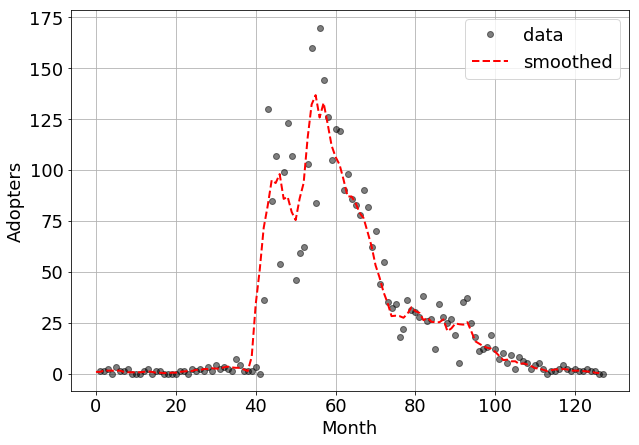

In [8]:
i=8
plt.figure(figsize=(10,7))
plt.plot(city_timelines.iloc[i,:],'ko',alpha=0.5,label="data")
plt.plot(smoothed.iloc[i],'r--',lw=2,label="smoothed")
plt.legend()
plt.xlabel('Month')
plt.ylabel("Adopters")
plt.grid()
plt.savefig("example_city_adoption_smoothed.png",density=300)
plt.show()

Storing empirical peak values.

In [9]:
empirical_peaks = smoothed.map(np.argmax)+1

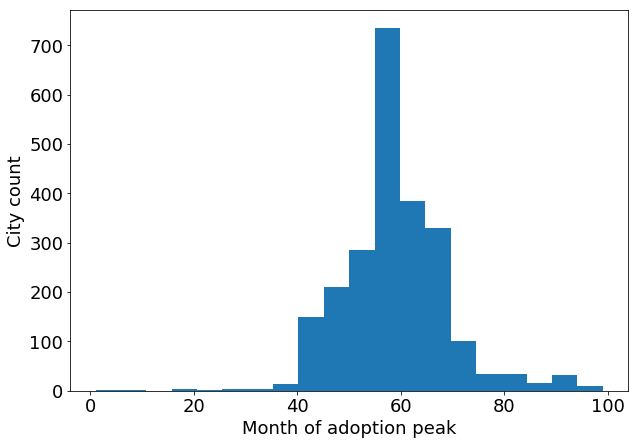

In [45]:
plt.hist(empirical_peaks,bins=20)
plt.xlabel("Month of adoption peak")
plt.ylabel("City count")
plt.show()

City size distribution.

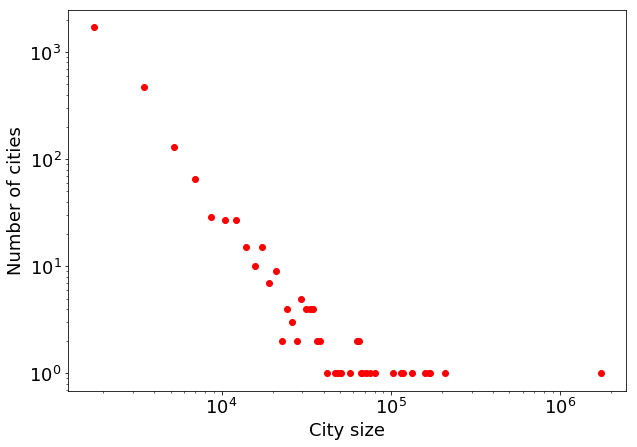

270 cities have a population bigger than 5000.


In [363]:
plt.figure(figsize=(10,7))
y,x = np.histogram(citydata["pop"],bins=1000)
plt.plot(x[1:],y,'ro')
plt.loglog()
plt.xlabel('City size')
plt.ylabel('Number of cities')
plt.show()

thres=5000
print(sum(citydata["pop"]>thres),' cities have a population bigger than ',thres, '.',sep='')

Running original simulation with best ABM parameter fits.

In [11]:
p_end = 0.00019396000397236234
q_end = 0.11907040888413596

In [12]:
conf = {"num_runs":10,"p":p_end,"q":q_end}
sim = SI(**conf)
simulation_result = sim.run_batch()

In [13]:
for k in simulation_result.keys():
    original_timeline[k] = original_timeline['id'].map({int(t):v for t,v in simulation_result[k]['time_infected'].items()})

Calculating peak adoption times for all cities from the ABM realizations, and then storing them along with the empirical peaks in a dataframe.

In [15]:
def smoothed_timeline(row,window=5):
    # smoothing a timeline from an array with a 5-month window (averaging values within the window)
    return np.convolve(np.ones(window),np.array(row),mode='same')/window

def smoothed_timeline_peak(row,window=5):
    # in which month does the previous timeline peak?
    y = np.convolve(np.ones(window),np.array(row),mode='same')/window
    return row.index[np.argmax(y)]

59.0, 63.0, 59.0, 66.0, 64.0, 63.0, 61.0, 59.0, 63.0, 65.0, 

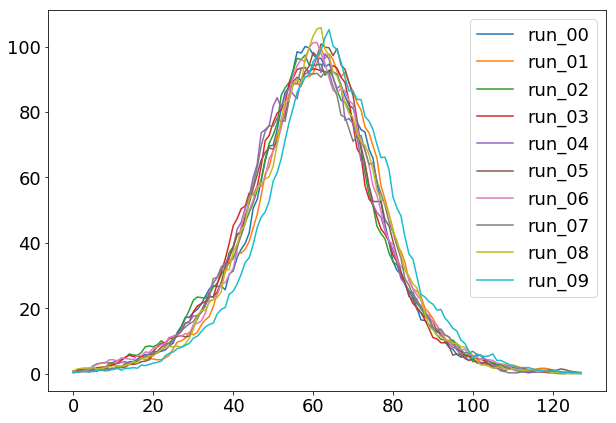

In [17]:
# sample plot fot the eigth city in the dataset with smoothing
# different ABM runs with the same parameters, how close are the peak months to each other?

i = 8
window = 5

for col in original_timeline.columns:
    if "run_0" in col:
        y = original_timeline.groupby(['cityid',col])\
            .count()[['id']].reset_index().pivot_table(index='cityid',columns=col,values="id",aggfunc=lambda x:x).fillna(0).iloc[i]
        plt.plot(smoothed_timeline(y),label=col)
        print(smoothed_timeline_peak(y),end=", ")
plt.legend()
plt.show()

In [19]:
# storing simulation city peak adoption times with 5-month window smoothing in a dataframe

In [18]:
data = {"data":empirical_peaks.to_dict()}

for col in simulation_result.keys():
    elem = original_timeline.groupby(['cityid',col])\
        .count()[['id']]\
        .reset_index()\
        .pivot_table(index='cityid',columns=col,values="id",aggfunc=lambda x:x).fillna(0)\
        .apply(lambda row: smoothed_timeline_peak(row,5),axis=1)
    data[col] = elem.to_dict()
data = pd.DataFrame(data)
data["pop"] = data.index.map(citydata["pop"])

In [29]:
data["run_avg"] = data.apply(lambda row: np.mean([row[k] for k in row.keys() if "run_0" in k]),axis=1)
rho,p = pearsonr(data[data["pop"]>5000].dropna()["data"],data[data["pop"]>5000].dropna()["run_avg"])

In [30]:
rhos = []
for col in data.columns:
    if "run_0" in col:
        rhos.append(pearsonr(data[data["pop"]>5000].dropna()["data"],data[data["pop"]>5000].dropna()[col])[0])
rhos

[0.07109192615334295,
 -0.055950950794716535,
 0.0444965219215733,
 0.0758110777620069,
 0.025948402127077667,
 -0.02194518955438429,
 0.0846675100722932,
 0.05036402254051965,
 0.06967890676996356,
 0.01864221498580717]

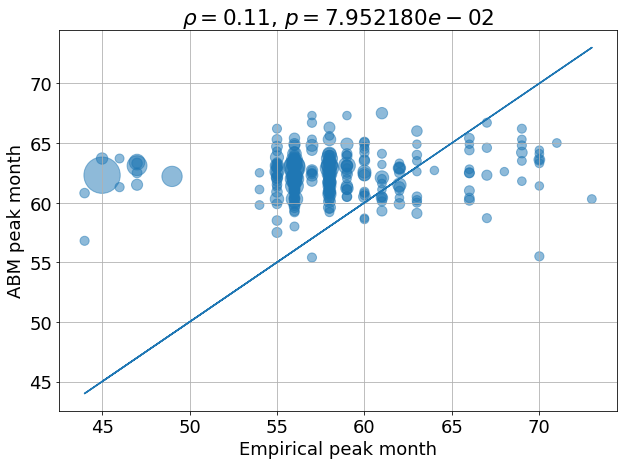

In [31]:
plt.figure(figsize=(10,7))
mask = data["pop"]>5000
plt.plot(figsize=(10,7))
plt.scatter(data[mask]["data"],data[mask]["run_avg"],s=np.sqrt(data[mask]["pop"]),alpha=0.5)
plt.xlabel("Empirical peak month")
plt.ylabel("ABM peak month")
plt.grid()
plt.title(r'$\rho=%.2f$, $p=%e$' % (rho,p))
plt.plot(data[mask]["data"],data[mask]["data"])
plt.savefig('empirical_vs_abm_peaks_all_cities.png',density=300)
plt.show()

In [22]:
# creating citywise peak adoption time dataframe from data exported to Balazs for easier visualization

original_timeline = pd.read_csv("vertices_fs.csv")
abms = pd.read_csv("adoption_times.csv").set_index("node_id")
df = original_timeline.set_index("id")[["cityid","month"]].join(abms).reset_index()

data = {}

for col in df.columns:
    if "id" not in col:
        elem = df.groupby(['cityid',col])\
            .count()[["id"]]\
            .reset_index()\
            .pivot_table(index='cityid',columns=col,values="id",aggfunc=lambda x:x).fillna(0)\
            .apply(lambda row: smoothed_timeline_peak(row,5),axis=1)
        data[col] = elem.to_dict()
data = pd.DataFrame(data)
data["pop"] = data.index.map(citydata["pop"])

data.reset_index().rename({"index":"cityid"},axis=1).to_csv("adoption_peaks.csv",index=False)

# Transformation

In [73]:
hvec = np.linspace(0,1,11) # all high values
lvec = np.linspace(0,1,11) # all low values

In [74]:
pairs = product(hvec,lvec) # all possible parameter pairs
p_end = 0.00019396000397236234
q_end = 0.11907040888413596

output = open('transformation_sweep_results.json','w') # storing simulation results
output2 = open('transformation_sweep_results_unagg.json','w')

for i,(h,l) in enumerate(pairs):
    print(i,end=", ")
    tic=time()
    conf = {"num_runs":5,"p":p_end,"q":q_end,"high":h,"low":l}
    sim = SI(**conf)
    unaggregated_res = sim.run_batch()
    res = sim.average_batch(unaggregated_res)
    
    unaggregated_res.update({"run_id":i})
    res.update({"run_id":i})
    
    output.write(json.dumps(res))
    output.write('\n')
    output2.write(json.dumps(unaggregated_res))
    output2.write('\n')
    
    toc=time()
        
output.close()
output2.close()

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 

In [97]:
temp = []
with open('transformation_sweep_results.json') as f:
    for line in f:
        temp.append(json.loads(line.strip('\n')))
transf_sweep_data = pd.DataFrame(temp)

transf_sweep_data["errors"] = transf_sweep_data['avg_timeline'].map(lambda x: np.sum((np.cumsum(x)-np.cumsum(original_data['avg_timeline']))**2))
error_matrx = transf_sweep_data.pivot_table(index='low',columns='high',values='errors',aggfunc=lambda x:x)

In [98]:
yx,xx = np.where(np.log10(error_matrx.values)<10.2)
dx = error_matrx.index[1]-error_matrx.index[0]
dy = error_matrx.columns[1]-error_matrx.columns[0]

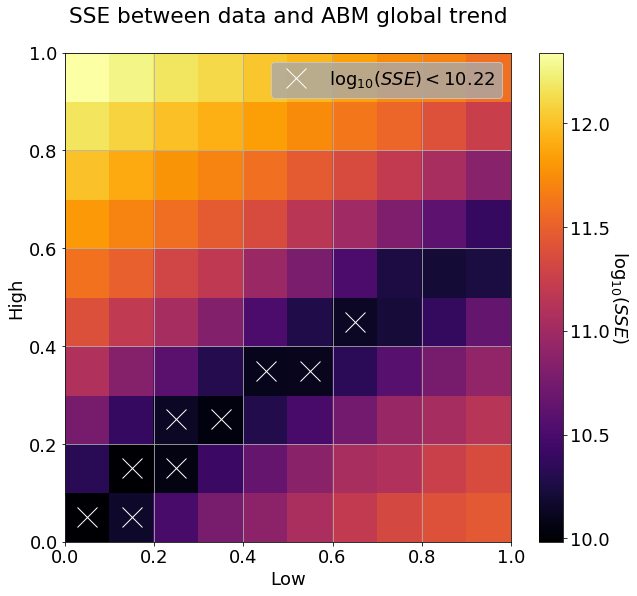

In [11]:
plt.figure(figsize=(10,9))
plt.pcolor(error_matrx.index,error_matrx.columns,np.log10(error_matrx.values),cmap='inferno')
plt.plot((xx+0.5)*dx,(yx+0.5)*dy,'wx',markersize=20,label=r"$\log_{10}(SSE)<10.22$")
cbar = plt.colorbar()
cbar.set_label(r"$\log_{10}(SSE)$",rotation=-90,labelpad=20)
plt.grid()
plt.xlabel("Low")
plt.ylabel("High")
plt.legend(facecolor='darkgrey')
plt.title("SSE between data and ABM global trend",pad=30)
plt.savefig('param_high_low_errors.png',density=300,bbox_inches='tight')
plt.show()

Plotting those AMS for which the global trend has a small error.

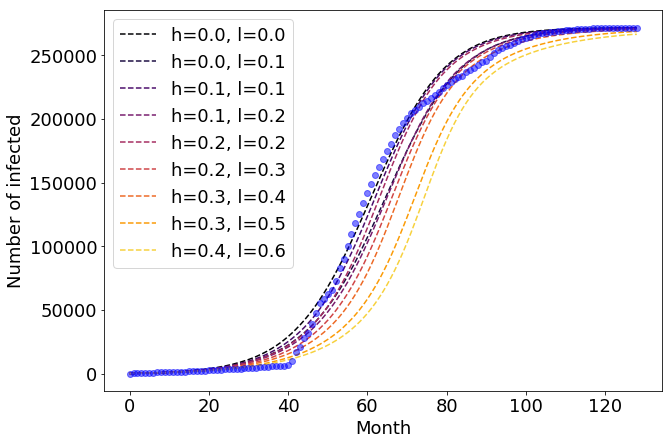

In [12]:
plt.figure(figsize=(10,7))
for i,(l,h) in enumerate(zip(xx*dx,yx*dy)):
    a = list(transf_sweep_data[(transf_sweep_data["low"]==l) & (transf_sweep_data["high"]==h)]["avg_timeline"])[0]
#     print(a)
    plt.plot(np.cumsum(a),'--',color=plt.cm.inferno(i/len(xx)),label="h=%.1f, l=%.1f" % (h,l))
plt.plot(original_data['avg_timeline'].cumsum(),'bo',alpha=0.5)
plt.legend()
plt.xlabel("Month")
plt.ylabel("Number of infected")
plt.savefig("global_transform_trends.png",density=300)

# Correlation of town peak adoption times

Loading results of simulations.

In [76]:
temp = []
with open('transformation_sweep_results_unagg.json') as f:
    for i,line in enumerate(f):
        print(i,end=", ")
        if i==0 or i==24:
            temp.append(json.loads(line.strip('\n')))
transf_unagg_sweep_data = pd.DataFrame(temp)
transf_unagg_sweep_data.set_index("run_id",inplace=True)
transf_unagg_sweep_data.head()

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 

,run_00,run_01,run_02,run_03,run_04
run_id,,,,,
0,"{'time_infected': {'72907840': 98, '63745298':...","{'time_infected': {'72907840': 71, '63745298':...","{'time_infected': {'72907840': 44, '63745298':...","{'time_infected': {'72907840': 71, '63745298':...","{'time_infected': {'72907840': 96, '63745298':..."
24,"{'time_infected': {'72907840': 77, '63745298':...","{'time_infected': {'72907840': 103, '63745298'...","{'time_infected': {'72907840': 88, '63745298':...","{'time_infected': {'72907840': 95, '63745298':...","{'time_infected': {'72907840': 81, '63745298':..."


In [88]:
np.where(transf_unagg_sweep_data.index==24)[0][0]

1

In [89]:
thres=5000

# numpy array for better/faster index axxess
transf_unagg_sweep_data_np = transf_unagg_sweep_data.iloc[:,0:5].values

# placeholders for the correlation values
transf_unagg_sweep_data["rho"] = None
transf_unagg_sweep_data["rho_trunc"] = None

def rho_calc(run_id):
    # calculating pearson correlation coefficient for a certain run_id between empirical and ABM adoption peaks
    print(run_id,end=", ")
    temp_peaks= []
    for r in transf_unagg_sweep_data.columns:
        if "run_0" in r:
            # getting timeline
            tline = {int(t):v for t,v in transf_unagg_sweep_data_np[np.where(transf_unagg_sweep_data.index==run_id)[0][0],int(r[-2:])]["time_infected"].items()}
            # adding timeline to original dataframe
            original_timeline.set_index("id",inplace=True)
            original_timeline["month_temp"] = original_timeline.index.map(tline)
            original_timeline.reset_index(inplace=True)
            
            temp = original_timeline[["id","cityid","month_temp"]].rename({"month_temp":"month"},axis=1)
            
            # calculating citywise peak adoption times for each run with the same parameters
            elem = temp.groupby(['cityid','month'])\
                .count()[['id']]\
                .reset_index()\
                .pivot_table(index='cityid',columns="month",values="id",aggfunc=lambda x:x).fillna(0)\
                .apply(smoothed_timeline_peak,axis=1)
            temp_peaks.append(elem)
    # concatenating average peak adoption times and empirical peak adoption times
    temp = pd.DataFrame([empirical_peaks,pd.DataFrame(temp_peaks).mean(axis=0)]).T
    temp.columns = ["run","data"]
    # measuring correlation between the two
    rho,p = pearsonr(temp.dropna()["data"],temp.dropna()["run"])
    # adding population
    temp["pop"] = temp.index.map(citydata["pop"])
    # measuring correlation only for the largest towns
    rho_trunc,p_trunc = pearsonr(temp[temp["pop"]>thres].dropna()["data"],temp[temp["pop"]>thres].dropna()["run"])
    # creating outputs in the original dataframe for both the untruncated and the truncated correlation values
    transf_unagg_sweep_data["rho"][run_id] = rho
    transf_unagg_sweep_data["rho_trunc"][run_id] = rho_trunc

In [90]:
# calculating correlations for all indices of the original dataframe
_ = transf_unagg_sweep_data.index.map(rho_calc)

0, 24, 

In [91]:
# getting parameters

transf_unagg_sweep_data["low"] = transf_unagg_sweep_data["run_00"].map(lambda t: t["low"])
transf_unagg_sweep_data["high"] = transf_unagg_sweep_data["run_00"].map(lambda t: t["high"])

Correlation data for all town sizes.

In [93]:
corr_data = transf_unagg_sweep_data.pivot_table(index='low',columns='high',values='rho',aggfunc=lambda x:x)

Correlation data for towns bigger than 5000 people.

In [94]:
corr_data2 = transf_unagg_sweep_data.pivot_table(index='low',columns='high',values='rho_trunc',aggfunc=lambda x:x)

Plotting correlation matrix.

In [100]:
corr_data2

high,0.0,0.2
low,,
0.0,0.139328,NaN
0.2,NaN,0.120215


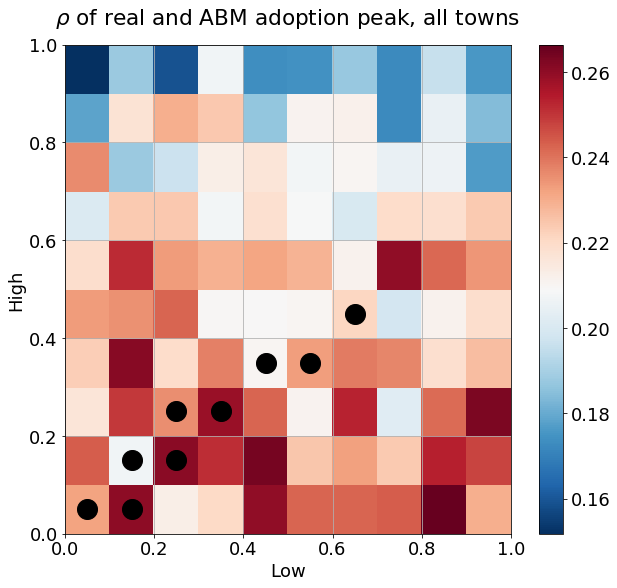

In [21]:
plt.figure(figsize=(10,9))
plt.pcolor(corr_data.index,corr_data.columns,corr_data.values,cmap='RdBu_r')
plt.colorbar()
plt.grid()
plt.xlabel("Low")
plt.ylabel("High")
plt.plot((xx+0.5)*dx,(yx+0.5)*dy,'ko',markersize=20,label=r"$\log_{10}(SSE)<10.22$")
plt.title(r"$\rho$ of real and ABM adoption peak, all towns",pad=20)
plt.savefig('param_high_low_corr_all.png',density=300)
plt.show()

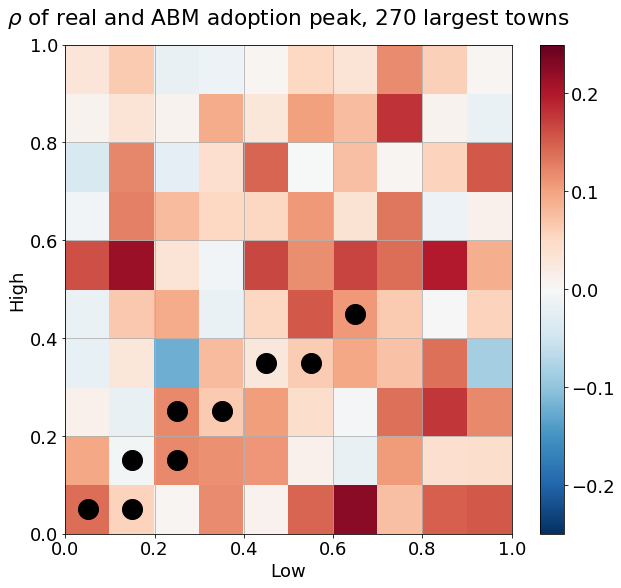

In [22]:
plt.figure(figsize=(10,9))
plt.pcolor(corr_data2.index,corr_data2.columns,corr_data2.values,cmap='RdBu_r',vmin=-0.25,vmax=0.25)
plt.colorbar()
plt.grid()
plt.xlabel("Low")
plt.ylabel("High")
plt.title(r"$\rho$ of real and ABM adoption peak, 270 largest towns",pad=20)
plt.plot((xx+0.5)*dx,(yx+0.5)*dy,'ko',markersize=20,label=r"$\log_{10}(SSE)<10.22$")
plt.savefig('param_high_low_corr_largest.png',density=300)
plt.show()

The selected squares of the previous two figures combined into one plot.

In [95]:
def return_peak_time_data(run_id):
    temp_peaks= []
    for r in transf_unagg_sweep_data.columns:
        if "run_" in r:
            tline = {int(t):v for t,v in transf_unagg_sweep_data_np[run_id,int(r[-2:])]["time_infected"].items()}
            
            original_timeline.set_index("id",inplace=True)
            original_timeline["month_temp"] = original_timeline.index.map(tline)
            original_timeline.reset_index(inplace=True)
            
            temp = original_timeline[["id","cityid","month_temp"]].rename({"month_temp":"month"},axis=1)
            
            elem = temp.groupby(['cityid','month'])\
                .count()[['id']]\
                .reset_index()\
                .sort_values('id', ascending=False)\
                .drop_duplicates(['cityid'])[["cityid","month"]]\
                .set_index("cityid")["month"]
            temp_peaks.append(elem)
    temp = pd.DataFrame([empirical_peaks,pd.DataFrame(temp_peaks).mean(axis=0)]).T
    temp.columns = ["run","data"]
    temp["pop"] = temp.index.map(citydata["pop"])
    return temp

IndexError: single positional indexer is out-of-bounds

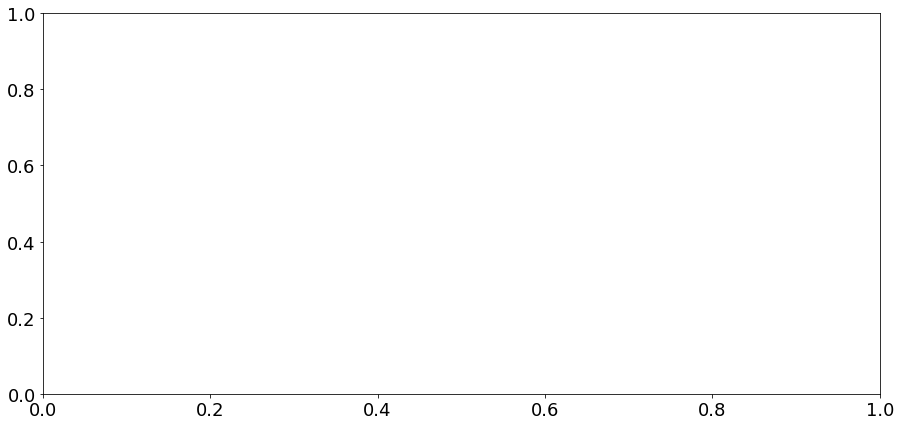

In [99]:
fig = plt.figure(figsize=(15,7))
ax=fig.gca()
xla = []
y1 = []
y2 = []

for i,(l,h) in enumerate(zip(xx*dx,yx*dy)):
    temp = transf_unagg_sweep_data[(transf_unagg_sweep_data["low"]==l) & (transf_unagg_sweep_data["high"]==h)]
    xla.append("h=%.2f, l=%.2f" % (h,l))
    y1.append(temp.iloc[0]["rho"])
    y2.append(temp.iloc[0]["rho_trunc"])

plt.plot(xla,y1,'bo',label="All towns")
plt.plot(xla,y2,'rs',label="Largest towns")
plt.plot(xla,np.zeros_like(xla),'k-')
ax.yaxis.set_ticks(np.linspace(-0.1,0.25,6))
ax.yaxis.set_ticklabels(["%.2f" % e for e in np.linspace(-0.1,0.25,6)])
ax.xaxis.set_ticklabels(xla,rotation=30,ha='right')
plt.legend()
plt.title("Correlation of empirical and ABM adoption peaks for best global fits",pad=30)
plt.grid()

ax1 = fig.add_axes([0.6,0.65,0.15,0.2],)
h=0.2
l=0.2
run_id = int(transf_unagg_sweep_data[(transf_sweep_data["low"]==l) & (transf_unagg_sweep_data["high"]==h)].index[0])
ax.plot(4,y2[4],'o',c='gray',markersize=20,alpha=0.5)
temp = return_peak_time_data(run_id)
ax1.scatter(temp[temp["pop"]>thres]["data"],temp[temp["pop"]>thres]["run"],color='red',s=np.sqrt(temp[temp["pop"]>thres]["pop"])/10,alpha=0.3)
ax1.plot(temp[temp["pop"]>thres]["data"],temp[temp["pop"]>thres]["data"],'k--',lw=0.5)
ax.annotate("", xy=(5,0.18), xycoords="data",xytext=(4,y2[4]),textcoords='data',arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc",color='gray'))
ax1.set_xlabel('Empirical')
ax1.set_ylabel('ABM')

# plt.savefig("transf_best_correlations.png",density=300,bbox_inches="tight")
plt.show()

# Adoption month differences from neighbors

First, creating numpy arrays from adoption times, then accessing adoption times of neighbors for each node using the adjacency matrix as a boolean indexer.

In [383]:
temp = {sim.indexmap[k]:v for k,v in zip(original_timeline["id"],original_timeline["month"])}
empirical_time_infected = np.zeros(len(sim.indexmap.keys()))
for k,v in temp.items():
    empirical_time_infected[k]=v
empirical_time_infected[empirical_time_infected==0] = np.nan

In [406]:
temp = {sim.indexmap[int(t)]:v for t,v in transf_unagg_sweep_data.iloc[24,]["run_00"]["time_infected"].items()}
time_infected = np.zeros(len(sim.indexmap.keys()))
for k,v in temp.items():
    time_infected[k]=v
time_infected[time_infected==0] = np.nan

In [423]:
temp = {sim.indexmap[int(t)]:v for t,v in transf_unagg_sweep_data.iloc[0,]["run_00"]["time_infected"].items()}
time_infected2 = np.zeros(len(sim.indexmap.keys()))
for k,v in temp.items():
    time_infected2[k]=v
time_infected2[time_infected2==0] = np.nan

In [ ]:
diff_etime = []
for i,t in enumerate(empirical_time_infected):
    if i%10000==0:
        print(i,end=", ")
    diff_etime.append(empirical_time_infected[i]-np.nanmean(empirical_time_infected[np.array(sim.A[i,:].todense(),dtype='bool')[0]]))
print()
   

In [407]:
diff_time = []
for i,t in enumerate(time_infected):
    if i%10000==0:
        print(i,end=", ")
    diff_time.append(time_infected[i]-np.nanmean(time_infected[np.array(sim.A[i,:].todense(),dtype='bool')[0]]))
print()

0, 

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 


In [424]:
diff_time2 = []
for i,t in enumerate(time_infected2):
    if i%10000==0:
        print(i,end=", ")
    diff_time2.append(time_infected2[i]-np.nanmean(time_infected2[np.array(sim.A[i,:].todense(),dtype='bool')[0]]))
print()

0, 

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 


/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


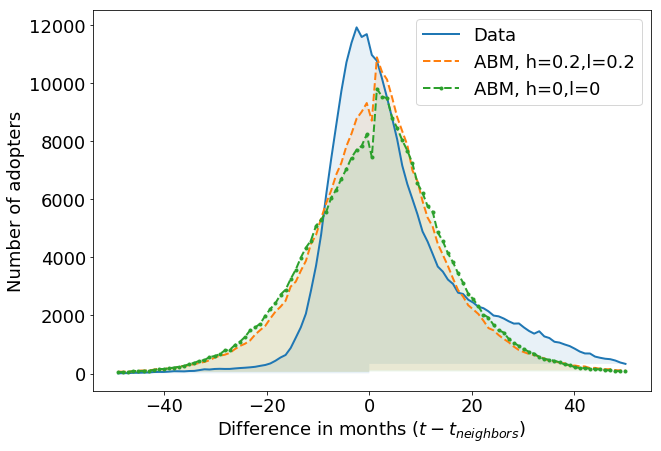

In [435]:
plt.figure(figsize=(10,7))

y1,x1 = np.histogram(diff_etime,bins=101,range=(-50,50))
plt.plot(x1[1:],y1,lw=2,label='Data')
plt.fill_betweenx(y1,x1[1:],x2=0,alpha=0.1)

y2,x2 = np.histogram(diff_time,bins=101,range=(-50,50))
plt.plot(x2[1:],y2,'--',lw=2,label='ABM, h=0.2,l=0.2')
plt.fill_betweenx(y2,x2[1:],x2=0,alpha=0.1)

y3,x3 = np.histogram(diff_time2,bins=101,range=(-50,50))
plt.plot(x3[1:],y3,'.--',lw=2,label='ABM, h=0,l=0')
plt.fill_betweenx(y3,x3[1:],x2=0,alpha=0.1)

plt.legend()
plt.xlabel(r"Difference in months ($t-t_{neighbors}$)")
plt.ylabel("Number of adopters")
plt.savefig("adoption_time_difference.png",density=300,bbox_inches="tight")

# Prediction failure in towns

In [28]:
df = pd.DataFrame(transf_unagg_sweep_data)

In [ ]:
h=0
l=0
temp1 = df[(df["low"]==l) & (df["high"]==h)]

h=0.2
l=0.2
temp2 = df[(df["low"]==l) & (df["high"]==h)]

peaks1 = return_peak_time_data(int(temp1.index[0]))
peaks1["pred_err"] = peaks1["run"]-peaks1["data"]

peaks2 = return_peak_time_data(int(temp2.index[0]))
peaks2["pred_err"] = peaks2["run"]-peaks2["data"]

y1,x1 = np.histogram(peaks1["pred_err"],bins=41,range=(-60,60))
y2,x2 = np.histogram(peaks2["pred_err"],bins=41,range=(-60,60))

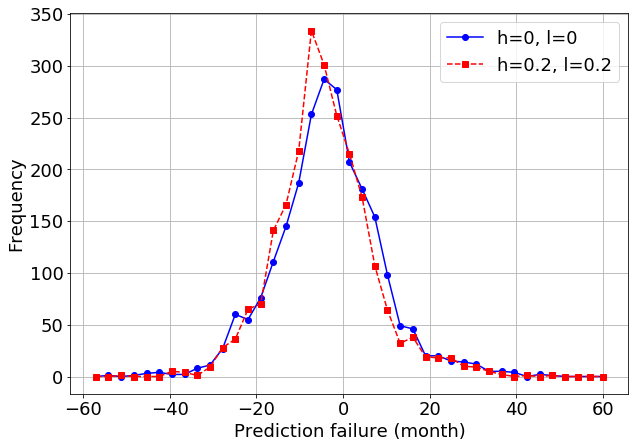

In [130]:
fig = plt.figure(figsize=(10,7))

plt.plot(x1[1:],y1,'bo-',label="h=0, l=0")
plt.plot(x2[1:],y2,'rs--',label="h=0.2, l=0.2")
plt.legend()
plt.grid()
plt.xlabel("Prediction failure (month)")
plt.ylabel("Frequency")

plt.savefig("pred_failure_different_models.png",density=300,bbox_inches="tight")

# Scaling of adopter types in towns

In [ ]:
# categorizing users as innovators, early adopters, majority and laggards bases on the percentiles
# from the article
# then counting each type within towns
# fitting scaling relationships to the different user types

In [103]:
ot = np.percentile(original_timeline["month"].dropna(),[0,2.5,15,100])
t1 = np.percentile(np.array(list(temp1.iloc[0]["run_00"]["time_infected"].values())),[0,2.5,15,100])
t2 = np.percentile(np.array(list(temp2.iloc[0]["run_00"]["time_infected"].values())),[0,2.5,15,100])

df1 = pd.DataFrame([
    original_timeline["cityid"],
    original_timeline["month"],
    original_timeline["id"].map({int(k):v for k,v in temp1.iloc[0]["run_00"]["time_infected"].items()})]).\
rename({"id":"run","month":"data"}).T


df2 = pd.DataFrame([
    original_timeline["cityid"],
    original_timeline["month"],
    original_timeline["id"].map({int(k):v for k,v in temp2.iloc[0]["run_00"]["time_infected"].items()})]).\
rename({"id":"run","month":"data"}).T

In [112]:
from scipy.optimize import curve_fit

In [123]:
def fit_scaling(x,y):
    def f(x,a,b):
        return a*x+b
    m = (x>1e4)&(y>0)
    p,pcov = curve_fit(f,np.log(x[m]),np.log(y[m]))
    return x[m],np.exp(f(np.log(x[m]),*p)),r"$\beta=%.3f$" % p[0]

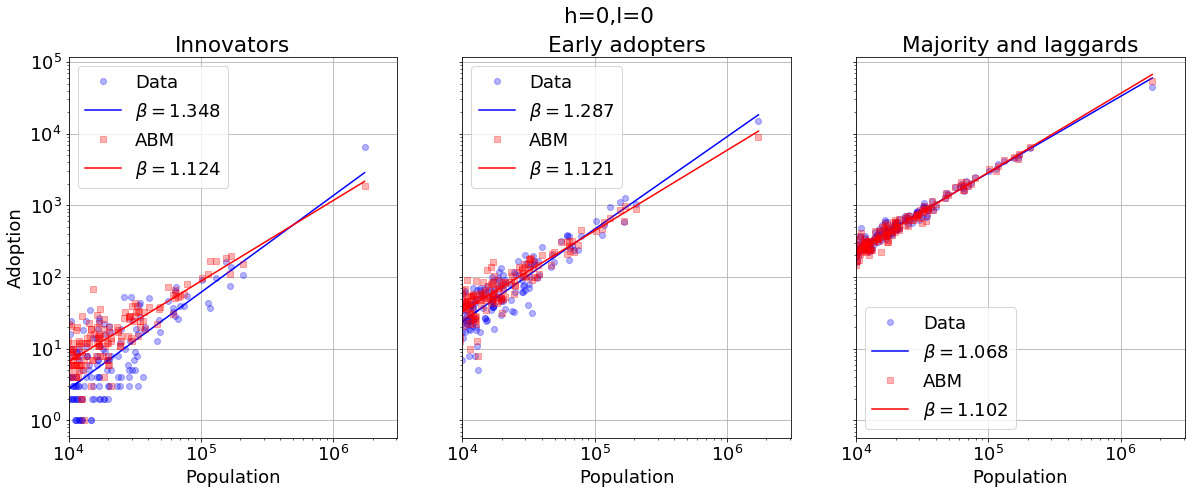

In [133]:
fig,ax = plt.subplots(1,3,figsize=(20,7),sharey=True)
titles = ["Innovators","Early adopters","Majority and laggards"]

fig.suptitle("h=0,l=0")

for p in range(3):
    scaling_data = pd.concat([
        citydata["pop"],
        df1[(df1["data"]>ot[p])&(df1["data"]<=ot[p+1])].groupby("cityid").count()["data"]],axis=1).fillna(0)

    scaling_run = pd.concat([
        citydata["pop"],
        df1[(df1["run"]>t1[p])&(df1["run"]<=t1[p+1])].groupby("cityid").count()["run"]],axis=1).fillna(0)
        
    ax[p].plot(scaling_data["pop"],scaling_data["data"],'bo',label="Data",alpha=0.3)
    x1f,y1f,l1 = fit_scaling(scaling_data["pop"],scaling_data["data"])
    ax[p].plot(x1f,y1f,'b-',label=l1)
    
    ax[p].plot(scaling_run["pop"],scaling_run["run"],'rs',label="ABM",alpha=0.3)
    x2f,y2f,l2 = fit_scaling(scaling_run["pop"],scaling_run["run"])
    ax[p].plot(x2f,y2f,'r-',label=l2)
    
    ax[p].loglog()
    ax[p].grid()
    ax[p].set_xlabel("Population")
    ax[p].legend()
    ax[p].set_xlim(1e4,)
    if p==0:
        ax[p].set_ylabel("Adoption")
    ax[p].set_title(titles[p])
plt.savefig("scaling_abm1.png",density=300,bbox_inches="tight")

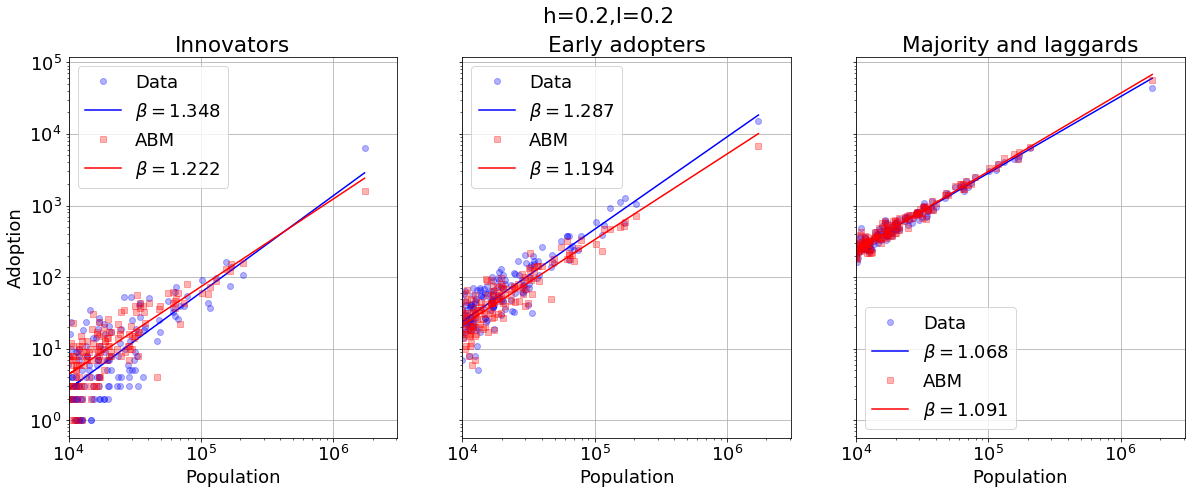

In [134]:
fig,ax = plt.subplots(1,3,figsize=(20,7),sharey=True)
titles = ["Innovators","Early adopters","Majority and laggards"]

fig.suptitle("h=0.2,l=0.2")

for p in range(3):
    scaling_data = pd.concat([
        citydata["pop"],
        df2[(df2["data"]>ot[p])&(df2["data"]<=ot[p+1])].groupby("cityid").count()["data"]],axis=1).fillna(0)

    scaling_run = pd.concat([
        citydata["pop"],
        df2[(df2["run"]>t1[p])&(df2["run"]<=t1[p+1])].groupby("cityid").count()["run"]],axis=1).fillna(0)
        
    ax[p].plot(scaling_data["pop"],scaling_data["data"],'bo',label="Data",alpha=0.3)
    x1f,y1f,l1 = fit_scaling(scaling_data["pop"],scaling_data["data"])
    ax[p].plot(x1f,y1f,'b-',label=l1)
    
    ax[p].plot(scaling_run["pop"],scaling_run["run"],'rs',label="ABM",alpha=0.3)
    x2f,y2f,l2 = fit_scaling(scaling_run["pop"],scaling_run["run"])
    ax[p].plot(x2f,y2f,'r-',label=l2)
    
    ax[p].loglog()
    ax[p].grid()
    ax[p].set_xlabel("Population")
    ax[p].legend()
    ax[p].set_xlim(1e4,)
    if p==0:
        ax[p].set_ylabel("Adoption")
    ax[p].set_title(titles[p])
plt.savefig("scaling_abm2.png",density=300,bbox_inches="tight")

# Adoption probability curve

In [4]:
from scipy.sparse import coo_matrix

In [7]:
p_end = 0.00019396000397236234
q_end = 0.11907040888413596

In [ ]:
conf = {"num_runs":10,"p":p_end,"q":q_end}
sim = SI(**conf)
simulation_result = sim.run_batch()

In [9]:
# creating a helper matrix, where B_ij = adoption_month(j), if ij is an edge
# filling up adjacency matrix 1-s with month values

nodes = pd.read_csv('./vertices_fs.csv').set_index("id")
month = dict(nodes["month"])
rev_month = {}
for k,v in month.items():
    if v in rev_month:
        rev_month[v].append(sim.indexmap[k])
    else:
        rev_month[v] = [sim.indexmap[k]]
rev_month = {k:np.array(v) for k,v in rev_month.items()}

In [10]:
month = {sim.indexmap[i]:month[i] for i in month}
B = sim.A.tocoo()
B.data = np.array([month[k] for k in range(max(sim.indexmap_back.keys()))])[sim.A.nonzero()[1]]

In [11]:
i,j = B.nonzero()
d = B.data

In [57]:
degrees = pd.DataFrame(np.array(sim.A.sum(axis=1).T)[0])

In [ ]:
# individual-level degree + N_j(t) at the time of the adoption

In [138]:
thresholds = {}
for m in range(1,128):
    print(m,end=", ")
    c1 = np.isin(i,rev_month[m])
    c2 = (d<=m)
    temp = pd.DataFrame(pd.DataFrame([i[c1&c2],d[c1&c2]]).T.groupby(0).count()).join(degrees).rename({1:"an",0:"n"},axis=1)
    for n,a in zip(temp["n"],temp["an"]/temp["n"]):
        if n in thresholds:
            thresholds[n].append(a)
        else:
            thresholds[n]=[a]

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 

0 99579


Text(0.5, 0, '$N_j(t)$')

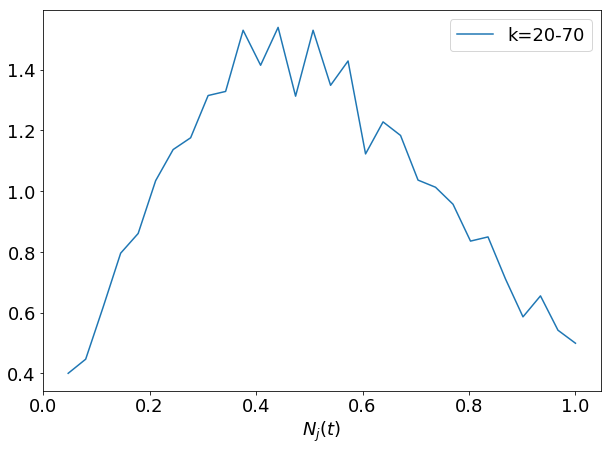

In [154]:
ranges=[20,70]
for i in range(len(ranges)-1):
    temp = []
    for k in thresholds.keys():
        if k>ranges[i] and k<=ranges[i+1]:
            temp.extend(thresholds[k])
    print(i,len(temp))
    y,x = np.histogram(temp,30,density=True)
    plt.plot(x[1:],y,label='k='+str(ranges[i])+'-'+str(ranges[i+1]))
plt.legend()
plt.xlabel(r"$N_j(t)$")

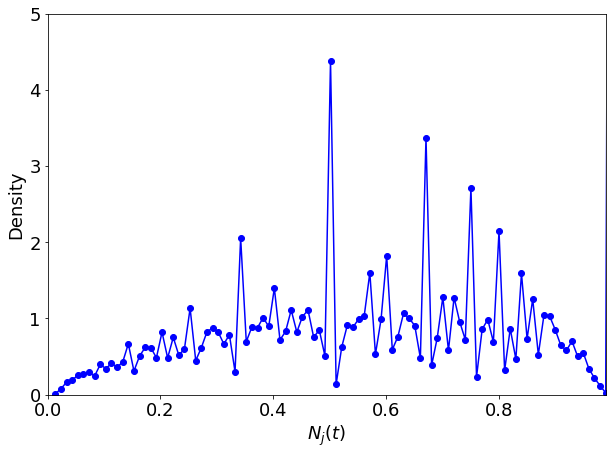

In [136]:
y,x = np.histogram(thresholds,100,density=True)
plt.plot(x[1:],y,'bo-')
plt.xlim(0,0.99)
plt.ylim(0,5)
plt.xlabel(r"$N_j(t)$")
plt.ylabel(r"Density")
plt.show()

# Plotting the transformation function

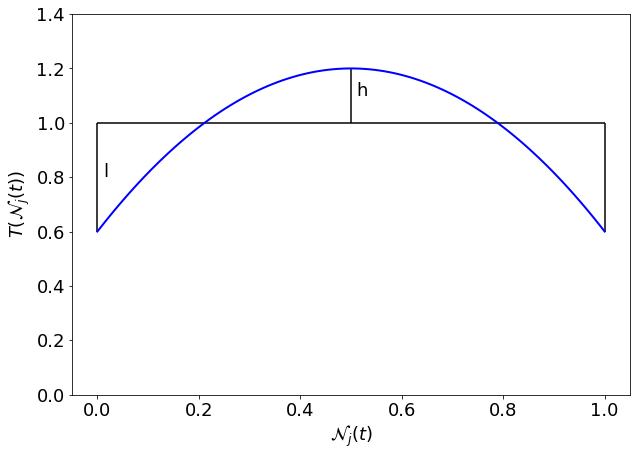

In [73]:
h=0.2
l=0.4
x = np.linspace(0,1,100)
y = -4*(h+l)*x**2+4*(h+l)*x-l+1
plt.plot(x,y,'b-',lw=2)

plt.hlines([1],0,1)
plt.vlines(0,1,1-l)
plt.vlines(1,1,1-l)
plt.vlines(0.5,1,1+h)

plt.annotate('l',(0.012,1-l/2))
plt.annotate('h',(0.51,1+h/2))

plt.xlabel(r'$\mathcal{N}_j(t)$')
plt.ylabel(r'$T(\mathcal{N}_j(t))$')

plt.xlim(-0.05,1.05)
plt.ylim(0,1.4)

plt.savefig('transform.png')